# Testing Markov Chain Monte Carlo sampling algorithm

@Author: Ettore Biondi - ebiondi@caltech.edu

## Problem definition

Now, we turn our attention onto sampling methods. We start with the very well-known sampling method called MCMC. We are going to extract samples of the following probability density function (PDF):
\begin{equation}
\phi(\mathbf{x}) = k_1 \exp^{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_1)^{T}\Sigma_1^{-1}(\mathbf{x}-\mathbf{\mu}_1)}+k_2 \exp^{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_2)^{T}\Sigma_2^{-1}(\mathbf{x}-\mathbf{\mu}_2)},
\end{equation}
where two Gaussian multivariate distributions have been normalized summed together.

In [1]:
import numpy as np
import occamypy as o

o.backend.set_seed_everywhere(42)

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


We first start by writing the problem class definition.

In [2]:
class TwoGaussians(o.Problem):
    """
    Two Gaussian modes in a 2D plane
    """

    def __init__(self, mu1, mu2, sigma1, sigma2):
        """        
        TwoGaussians constructor
        
        Args:
            mu1: 1D array - mean of the gaussian function 1
            mu2: 1D array - mean of the gaussian function 2
            sigma1: 2D array - variance matrix of gaussian function 1
            sigma2: 2D array - variance matrix of gaussian function 2
        """
        super(TwoGaussians, self).__init__(model=o.VectorNumpy(mu1.shape), data=o.VectorNumpy((1,)))
        
        # Gaussian parameters
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma1_inv = np.linalg.inv(sigma1)
        self.sigma2_inv = np.linalg.inv(sigma2)
        self.scale1 = 0.5 / (np.sqrt(np.linalg.det(sigma1) * (2.0 * np.pi) ** self.mu1.shape[0]))
        self.scale2 = 0.5 / (np.sqrt(np.linalg.det(sigma2) * (2.0 * np.pi) ** self.mu2.shape[0]))
        
        # Gradient vector
        self.grad = self.pert_model.clone()
        
        self.setDefaults()
        self.linear = False
    
    def res_func(self, model):
        """Residual function"""
        m1 = model[:] - self.mu1
        m2 = model[:] - self.mu2
        self.res[0] = self.scale1 * np.exp(-0.5 * np.dot(m1, np.dot(self.sigma1_inv, m1))) + \
                      self.scale2 * np.exp(-0.5 * np.dot(m2, np.dot(self.sigma2_inv, m2)))
        return self.res
    
    def obj_func(self, residual):
        """Objective function computation"""
        obj = residual[0]
        return obj

## Build the PDF

In [3]:
mu1 = np.array([2.0, 1.5])
mu2 = np.array([-1.5, -3.0])
sigma1 = np.array([[1., 3. / 5.], [3. / 5., 2.]])
sigma2 = np.array([[2., -3. / 5.], [-3. / 5., 1.]])

problem = TwoGaussians(mu1, mu2, sigma1, sigma2)

Let's now perform an extensive search, which will help us understand how the sampling method is performing on this PDF.

In [4]:
#Computing the objective function for plotting
xaxis = np.linspace(-5.,5.,100)
yaxis = np.linspace(-6.,6.,110)

pdf = o.VectorNumpy((yaxis.size, xaxis.size))
sample = o.VectorNumpy((2,))

for iy, y in enumerate(yaxis):
    for ix, x in enumerate(xaxis):
        sample[:]  = y, x
        pdf[iy,ix] = problem.get_obj(sample)

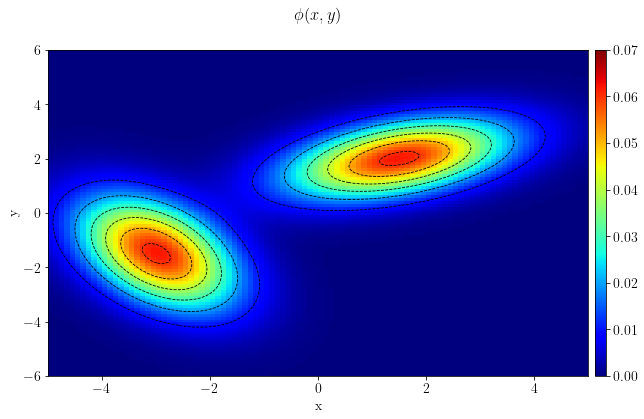

In [5]:
fig, ax = plt.subplots()

im = plt.imshow(np.flip(pdf.plot(), axis=0), clim=(0,.07), extent=[-5.,5.,-6.,6.0])

ax.set_xlabel("x"), ax.set_ylabel("y")

cs = plt.contour(xaxis, yaxis, pdf.plot(),
                 levels=[0.01,0.02,0.03,0.04,0.05,0.06],
                 colors="black", linewidths=(0.8,), linestyles='--')

plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="2%", pad=0.1))
plt.suptitle(r"$\phi(x,y)$")
plt.show()

## Sample the PDF with a MCMC method

In [6]:
MCMCsampler = o.MCMC(stopper=o.SamplingStopper(10000), prop_distr="u", max_step=2.5)
MCMCsampler.setDefaults()

MCMCsampler.run(problem, verbose=False)

In [7]:
# Converting sampled points to arrays for plotting
burn_samples = 500
MCMC_samples = np.array([MCMCsampler.model[i].getNdArray()
                         for i in range(burn_samples, len(MCMCsampler.model))], copy=False)

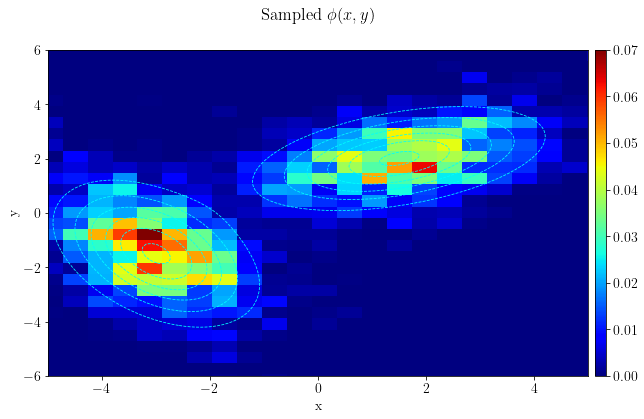

In [8]:
fig, ax = plt.subplots()

plt.hist2d(MCMC_samples[:,1], MCMC_samples[:,0], bins=[30,30])

ax.set_xlabel("x"), ax.set_ylabel("y")
ax.set_xlim(-5,5), ax.set_ylim(-6,6)

cs = plt.contour(xaxis, yaxis, pdf.plot(),
                 levels=[0.01,0.02,0.03,0.04,0.05,0.06], 
                 colors="cyan", linewidths=(0.8,), linestyles='--')

plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="2%", pad=0.1))
plt.suptitle(r"Sampled $\phi(x,y)$")
plt.show()